In [1]:
import tensorflow as tf
from tensorflow import keras

import seaborn as sn
import numpy as np
import srsly
import random
import spacy
import pandas as pd
import sqlite3

In [2]:
import sys
sys.path.append('../../')

from src.models.text_classification.train_classifier import retrieve_dataset, merge_labels

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
nlp.disable_pipes('tagger', 'parser', 'ner')

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7fd3dbd4ef60>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fd3dbd86ee8>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fd3dbd86f48>)]

In [52]:
USE_VECTORS = True
MAXLEN_SEQUENCE = 300
KEEP = 'first' # | last
MERGE_LABELS = True
LABELS = ['TYPE_A', 'TYPE_B']

In [55]:
def merge_labels(dataset):                                                                                                                                                                                           
    for split, examples in dataset.items():
        to_pop = []
        for i, example in enumerate(examples):                                                                                                                                                                                     
            labels = example['label_names']                                                                                                                                                                          
            if set(labels ) == {'TYPE_A', 'APPROVED', 'REGULAR_LANGUAGE'}:                                                                                                                                           
                labels = ['FAVOR_INDIVIDUAL']                                                                                                                                                                        
            elif set(labels ) == {'TYPE_A', 'DISMISSED', 'REGULAR_LANGUAGE'}:                                                                                                                                        
                labels = ['FAVOR_HOME_OFFICE']                                                                                                                                                                       
            elif set(labels ) == {'TYPE_B', 'APPROVED', 'REGULAR_LANGUAGE'}:                                                                                                                                         
                labels = ['FAVOR_HOME_OFFICE']                                                                                                                                                                       
            elif set(labels ) == {'TYPE_B', 'DISMISSED', 'REGULAR_LANGUAGE'}:                                                                                                                                        
                labels = ['FAVOR_INDIVIDUAL']                                                                                                                                                                        
            elif set(labels ) == {'TYPE_B', 'APPROVED', 'REVERSE_LANGUAGE'}:                                                                                                                                          
                labels = ['FAVOR_INDIVIDUAL']                                                                                                                                                                        
            elif set(labels ) == {'TYPE_B', 'DISMISSED', 'REVERSE_LANGUAGE'}:                                                                                                                                        
                labels = ['FAVOR_HOME_OFFICE']                                                                                                                                                                       
            elif 'RETURN_TO_TRIAL' in labels:                                                                                                                                                                        
                labels = ['RETURN_TO_TRIAL']
            else:
                to_pop.append(i)
            example['label_names'] = labels
        for idx in to_pop[::-1]:
            examples.pop(idx)

In [56]:
connection = sqlite3.connect('../../data/processed/database.sqlite')

if MERGE_LABELS:
    classes = [                                                                                                                                                                                                      
        'REGULAR_LANGUAGE', 'TYPE_A', 'REVERSE_LANGUAGE', 'APPROVED', 'TYPE_B',                                                                                                                                      
        'DISMISSED', 'RETURN_TO_TRIAL'                                                                                                                                                                               
    ]
    dataset = retrieve_dataset(connection, classes=classes)
    merge_labels(dataset)
    LABELS = ['FAVOR_INDIVIDUAL', 'FAVOR_HOME_OFFICE', 'RETURN_TO_TRIAL']
else:
    dataset = retrieve_datast(connection, classes=LABELS)

In [57]:
from collections import Counter
Counter(tuple(sorted(example['label_names'])) for split, examples in dataset.items() for example in examples)

Counter({('RETURN_TO_TRIAL',): 118,
         ('FAVOR_HOME_OFFICE',): 237,
         ('FAVOR_INDIVIDUAL',): 118})

In [58]:
random.seed(42)

In [59]:
train_raw_data_orig = dataset['train']
test_raw_data = dataset['validation']

In [60]:
len(train_raw_data_orig), len(test_raw_data)

(334, 71)

In [61]:
from copy import deepcopy

def augment_example_switch(example, p_changes=20):
    text = example['text']
    words = text.split()
    n_changes = int(p_changes*len(words))
    n = len(words)
    for i in range(n_changes):
        pivot = random.randint(0, n - 2)
        w = words[pivot]
        words[pivot] = words[pivot + 1]
        words[pivot + 1] = w
    ex2 = deepcopy(example)
    ex2['text'] = ' '.join(words)
    return ex2


def augment_example_remove(example, p_changes=20):
    text = example['text']
    words = text.split()
    n_changes = int(p_changes*len(words))
    n = len(words)
    for i in range(n_changes):
        idx = random.randint(0, n - 2)
        words = words[:idx] + words[idx + 1:]
    ex2 = deepcopy(example)
    ex2['text'] = ' '.join(words)
    return ex2


def data_augmentation_switch(data, n, p_changes):
    new_data = data
    for i in range(n):
        new_data = new_data + [augment_example_switch(example, p_changes) for example in data]
    return new_data


def data_augmentation_remove(data, n, p_changes):
    new_data = data
    for i in range(n):
        new_data = new_data + [augment_example_remove(example, p_changes) for example in data]
    return new_data

In [62]:
# train_raw_data = data_augmentation_switch(data_augmentation_remove(train_raw_data_orig, 4, 0.2), 4, 0.2)
# random.shuffle(train_raw_data)

In [63]:
train_raw_data = train_raw_data_orig[:]

In [64]:
docs_train = [doc for doc in nlp.pipe(e['text'].lower() for e in train_raw_data)]
docs_test = [doc for doc in nlp.pipe(e['text'].lower() for e in test_raw_data)]

In [65]:
vocab_size = 2000

word_index = dict()
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2 # unknown
word_index['<UNUSED>'] = 3

def doc_to_ints(doc):
    n = len(doc)
    for i in range(MAXLEN_SEQUENCE - n - 1):
        yield word_index['<PAD>']
    yield word_index['<START>']
    for token in doc:
        key = token.text
        if len(word_index) >= vocab_size - 1 and key not in word_index:
            yield word_index['<UNK>']
        elif key not in word_index:
            i = len(word_index) + 1
            word_index[key] = i
            yield i
        else:
            yield word_index[key]
            
def doc_to_vecs(doc, maxlen_sequence=500):
    if KEEP == 'last':
        keep_doc = doc[-maxlen_sequence + 1:]
    elif KEEP == 'first':
        keep_doc = doc[:maxlen_sequence - 1]
    else:
        raise Exception('KEEP should be first|last.')
    n = len(keep_doc)
    for i in range(maxlen_sequence - n - 1):
        yield np.zeros(doc.vocab.vectors.shape[1]) + word_index['<PAD>']
    yield np.zeros(doc.vocab.vectors.shape[1]) + word_index['<START>']
    for tk in keep_doc:
        word = tk.text
        if word == '<PAD>':
            yield np.zeros(nlp.vocab.vectors.shape[1]) + word_index['<PAD>']
            continue
        word_hash = doc.vocab.strings[word]
        if word_hash in doc.vocab.vectors:
            yield doc.vocab.vectors[word_hash]
        else:
            yield np.zeros(nlp.vocab.vectors.shape[1]) + word_index['<UNK>']

In [66]:
train_labels = np.array([LABELS.index(example['label_names'][0]) for example in train_raw_data])
test_labels = np.array([LABELS.index(example['label_names'][0]) for example in test_raw_data])

train_labels = keras.utils.to_categorical(train_labels, num_classes=len(LABELS))
test_labels = keras.utils.to_categorical(test_labels, num_classes=len(LABELS))

In [67]:
if USE_VECTORS:
    train_data = np.array([list(doc_to_vecs(doc, MAXLEN_SEQUENCE)) for doc in docs_train])
    test_data = np.array([list(doc_to_vecs(doc, MAXLEN_SEQUENCE)) for doc in docs_test])
else:
    train_data = np.array([list(doc_to_ints(doc)) for doc in docs_train])
    test_data = np.array([list(doc_to_ints(doc)) for doc in docs_test])

In [68]:
class MyModel_simple(keras.Sequential):
    def __init__(self):
        super(MyModel_simple, self).__init__()
        self.conv1 = keras.layers.Conv1D(filters=256,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1)
        self.max_pooling = keras.layers.GlobalMaxPooling1D()
        self.d1 = keras.layers.Dense(128, activation='relu', )
        self.d1_drop = keras.layers.Dropout(0.5)
        self.d2 = keras.layers.Dense(len(LABELS), activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.max_pooling(x)
        x = self.d1_drop(self.d1(x))
        return self.d2(x)
    
class MyModel_lstm(keras.Sequential):
    def __init__(self):
        super(MyModel_lstm, self).__init__()
        self.lstm = keras.layers.LSTM(32)
        self.d1 = keras.layers.Dense(32, activation='relu')
        self.d1_drop = keras.layers.Dropout(0.5)
        self.d2 = keras.layers.Dense(len(LABELS), activation='softmax')
        
    def call(self, x):
        x = self.lstm(x)
        x = self.d1(x)
        x = self.d1_drop(x)
        x = self.d2(x)
        return x

class MyModel_conv_lstm(keras.Sequential):
    def __init__(self):
        super(MyModel_conv_lstm, self).__init__()
        self.conv1 = keras.layers.Conv1D(filters=256,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1)
        self.max_pooling = keras.layers.GlobalMaxPooling1D()
        self.d1 = keras.layers.Dense(128, activation='relu', )
        self.d1_drop = keras.layers.Dropout(0.5)
        self.d2 = keras.layers.Dense(len(LABELS), activation='softmax')
        
        self.lstm = keras.layers.LSTM(256, dropout=0.5) #, recurrent_dropout=0.5)
        self.concat = keras.layers.Concatenate()
        
    def call(self, x):
        c_1 = self.conv1(x)
        c_2 = self.max_pooling(c_1)
        l_1 = self.lstm(x)
        conc = self.concat([c_2, l_1])
        conc_2 = self.d1_drop(self.d1(conc))
        return self.d2(conc_2)
    
class MyModel_convs(keras.Sequential):
    def __init__(self):
        super(MyModel_convs, self).__init__()
        self.conv1 = keras.layers.Conv1D(filters=64,
                 kernel_size=2,
                 padding='valid',
                 activation='relu',
                 strides=1)
        self.conv2 = keras.layers.Conv1D(filters=64,
                 kernel_size=3,
                 padding='valid',
                 activation='relu',
                 strides=1)
        self.conv3 = keras.layers.Conv1D(filters=64,
                 kernel_size=4,
                 padding='valid',
                 activation='relu',
                 strides=1)
        self.max_pooling = keras.layers.GlobalMaxPooling1D()
        self.d1 = keras.layers.Dense(128, activation='relu', )
        self.d1_drop = keras.layers.Dropout(0.5)
        self.d2 = keras.layers.Dense(len(LABELS), activation='softmax')
        
    def call(self, x):
        c_1 = self.max_pooling(self.conv1(x))
        c_2 = self.max_pooling(self.conv2(x))
        c_3 = self.max_pooling(self.conv3(x))
        conc = keras.layers.Concatenate()([c_1, c_2, c_3])
        conc_2 = self.d1_drop(self.d1(conc))
        return self.d2(conc_2)
    
model = MyModel_lstm()
model.build((None, MAXLEN_SEQUENCE, nlp.vocab.vectors.shape[1]))
model.summary()

Model: "my_model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "my_model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [71]:
from collections import Counter
import numpy as np
def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    
    Rows are scores for each class. 
    Columns are predictions (samples).
    """
    scoreMatExp = np.exp(np.asarray(x))
    return scoreMatExp / scoreMatExp.sum(0)

label_counts = sorted(Counter(train_labels.argmax(axis=1)).items())
label_counts

total_counts = train_labels.shape[0]
labels, counts = zip(*label_counts)
weights = 1 - softmax(np.array(counts) / total_counts)

class_weights = dict(zip(labels, weights))

In [72]:
total_counts = train_labels.shape[0]
labels, counts = zip(*label_counts)
weights = 1 - softmax(np.array(counts) / total_counts)

class_weights = dict(zip(labels, weights))

In [73]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((334, 300, 300), (71, 300, 300), (334, 3), (71, 3))

In [74]:
mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')
tensorboard = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
                                          write_graph=True, write_images=True)

In [75]:
LABELS,class_weights

(['FAVOR_INDIVIDUAL', 'FAVOR_HOME_OFFICE', 'RETURN_TO_TRIAL'],
 {0: 0.6973587894112157, 1: 0.602576258569336, 2: 0.7000649520194484})

In [76]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=20,
                    validation_data=(test_data, test_labels), #(x_val, y_val),
                    verbose=1,
                    class_weight=class_weights,
                   )

Epoch 1/10
17/17 [==============================] - 1s 45ms/step - loss: 0.7062 - accuracy: 0.4371 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 2/10
17/17 [==============================] - 0s 20ms/step - loss: 0.7005 - accuracy: 0.4251 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 3/10
17/17 [==============================] - 0s 21ms/step - loss: 0.6979 - accuracy: 0.4581 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 4/10
17/17 [==============================] - 0s 21ms/step - loss: 0.7053 - accuracy: 0.4311 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 5/10
17/17 [==============================] - 0s 20ms/step - loss: 0.6903 - accuracy: 0.4731 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 6/10
17/17 [==============================] - 0s 20ms/step - loss: 0.7009 - accuracy: 0.4521 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 7/10
17/17 [==============================] - 0s 20ms/step - loss: 0.7050 - accuracy: 0.4401 - val_loss: 1.0588 - val_accuracy: 0.5070
Epoch 8/10
17

In [314]:
model.load_weights('./.mdl_wts.hdf5', )

In [315]:
preds = model.predict(test_data).argmax(axis=1)
(test_labels.argmax(axis=1) == preds).sum() / test_labels.shape[0]

0.25

In [303]:
from sklearn.metrics import confusion_matrix

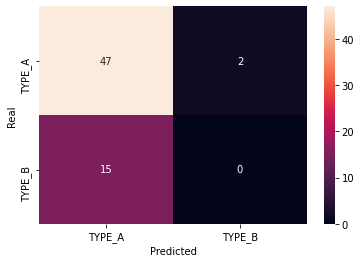

In [304]:
cm = confusion_matrix(test_labels.argmax(axis=1), preds)
df_cm = pd.DataFrame(cm,
                     index=LABELS,                                                   
                     columns=LABELS)
df_cm.columns.name = 'Predicted'                                                      
df_cm.index.name = 'Real'
sn.heatmap(df_cm, annot=True)                                                                                                       

In [305]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print(classification_report(test_labels.argmax(axis=1), preds, target_names=LABELS))

              precision    recall  f1-score   support

      TYPE_A       0.76      0.96      0.85        49
      TYPE_B       0.00      0.00      0.00        15

    accuracy                           0.73        64
   macro avg       0.38      0.48      0.42        64
weighted avg       0.58      0.73      0.65        64



In [151]:
test_labels.shape

(64, 2)

In [152]:
((test_labels.argmax(axis=1) == 0) & (preds == 2)).sum()

0

In [153]:
def predict(text):
    preds = model.predict(np.array([list(doc_to_vecs(nlp(text), MAXLEN_SEQUENCE))])).reshape(-1)
    return LABELS[preds.argmax()]

In [154]:
predict('i remake the decision and allow the appeal')

'TYPE_A'

In [155]:
predict('the decision shall stand')

'TYPE_A'

In [156]:
predict('the first tier tribunal erred in law and thus I remake the decision allowing it')

'TYPE_A'

In [ ]:
predict('the first tier tribunal erred in law and thus I remake the decision dismissing it')

In [ ]:
predict('the first tier tribunal erred in law and thus I remake the decision allowing it')

In [ ]:
predict('I remit back to the First-Tier Tribunal before a judge other than Pierre')